## Problem Statement
Hearing a species in a tropical rainforest is much more easier than seeing them and that is what we are going to do in this case study. We will be building model that can detect the species just by audio signals. If someone is in the forest, he might not be able to look around and see every type of  bird and frog that are there but they can be heard, now the problem is that everyone is not expert to recognise the species and take suitable action but we can build a device that recognise the species in real time and with the help of experts, a suitable action may also be suggested such as if the species is dangerous then he might need to run away.

## Real World Constraint
* If this solution is to be productionised we need to make sure that it doesn’t require too much resources because this solution will be used in small and simple devices and not in super computers.
* The latency should be as low as possible, we should try that it should not take more than 1 second to predict because if we are using a device in forest then we need our device to identify the species as soon as it is heard.
* Number of  false_negative should be as low as possible because if a dangerous species is there and our model doesn’t predict it then it may cost someone his life.
* The model will be trained using fixed length audio signals but in real time audio will be fed continuously to the device, so we need to find a solution for this problem, we will discuss about it in First Cut Approach section.

## Dataset Overview
We are given 4727 audio files and each of the audio was recorded in Tropical Forest, the data was collected through a device which along with recording audio also detects which species voice is there in the audio, later this data was manually checked by experts and now for around 1100 of these files we are given which species was detected by the device and experts also found it to be true(train_tp.csv) and for another 3600 files, we are given which species were detected by the device but experts found it to be false(train_fp.csv). Multiple species can be present in one audio, our task is to predict the probability of each of the species for around 1900 test files that we are given.

## Performance Metrics
As we need to predict probabilities instead of actual class labels, using Multiclass logloss would be a better option instead of using accuracy. It is defined as -ve average of log(probability of actual class label). Mathmatically, it is defined as-
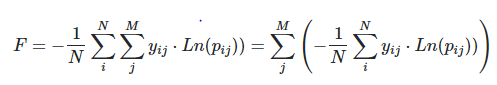
Where F is loss, pij is the probability output by the classifier, yij is the binary variable(1 if expected label, 0 otherwise), N is number of samples, M is number of classes.

In easy language, we can define it as-
       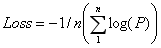
Where P is Probablity of actual class label and n is number of samples.

## Importing Required Libraries and loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tnrange
import librosa
import pickle
import numpy as np
from scipy.fft import fft
from tqdm.notebook import tqdm
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'
data=pd.read_csv('/kaggle/input/rfcx-species-audio-detection/train_tp.csv')

In [2]:
data.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


# 1. Exploratory Data Analysis

### 1.1 Null value analysis

In [3]:
data.isna().sum()

recording_id    0
species_id      0
songtype_id     0
t_min           0
f_min           0
t_max           0
f_max           0
dtype: int64

We don't have any null values.

### 1.2 Is our data balanced ?

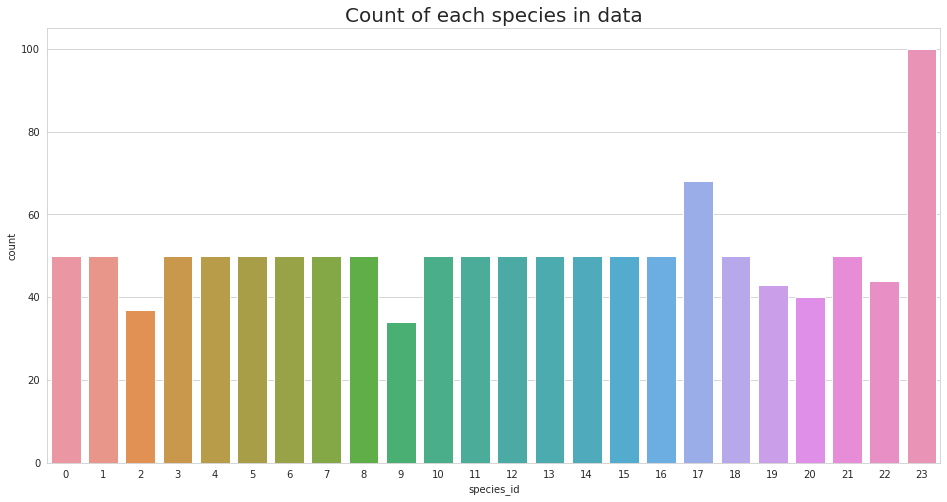

In [4]:
plt.figure(figsize=(16,8))
plt.title('Count of each species in data', fontsize=20)
sns.countplot(x='species_id', data = data)
plt.show()

Out of 24 classes, only one class has very large number of data points compared to other classes. So, we can conclude that our data is almost balanced.

### 1.3 More than 1 species in one audio file ? 

We discussed that one audio file may contain multiple species, so now we will check how many audio contain multiple species and how we will deal with them.

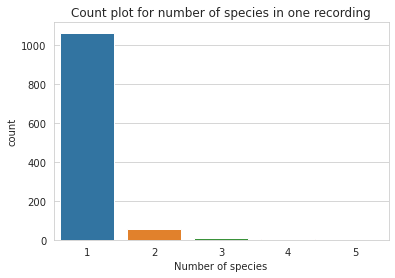

In [25]:
# In csv file, for each audio file we are given at what time a particular species was heard, 
# so one recording can be repeated multiple times in that csv file if it contains more than one species.
# So, we will look how many time one recording id gets repeated in the data.

# Count plot for number of species in audio files
sns.countplot(data['recording_id'].value_counts())
plt.title('Count plot for number of species in one recording')
plt.xlabel('Number of species')
plt.show()

We can easily observe that most of the audio file contain one species only and there are very few audio files that contain multiple species.          
Now, for example let's take an audio file that has 3 species and from the data that we are given we already know at what time in that file each of the species was heard. From this, we can slice this audio sequence in three parts such that each of the part contains only one species.

### 1.4 Does species depends on minimum frquency ?

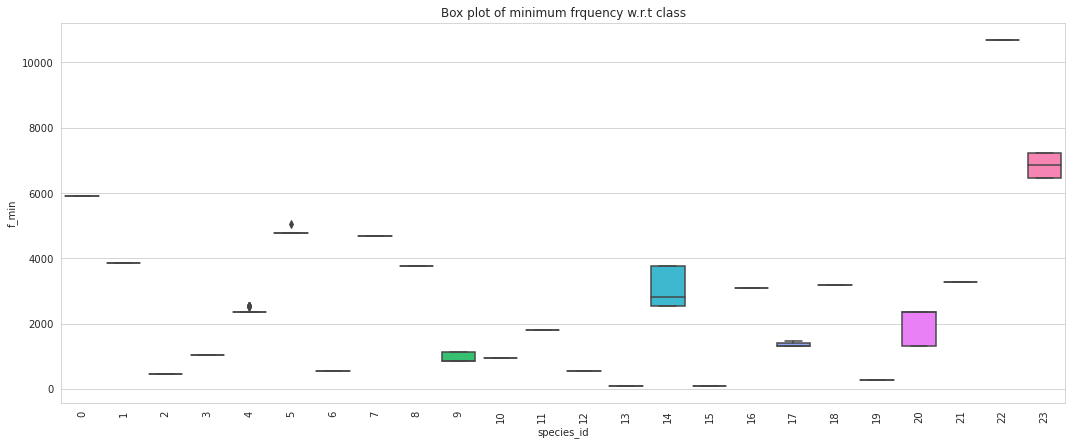

In [5]:
# Visualising box plot of minimum frequency w.r.t each class
plt.figure(figsize=(18,7))
sns.boxplot(x='species_id', y='f_min',data=data,saturation=1)
plt.title('Box plot of minimum frquency w.r.t class')
plt.ylabel('f_min')
plt.xticks(rotation=90)
plt.show()

We can see that some of the classes are easily separable.                    
If f_min>10000,then species =22                       
   8000>f_min>6000, then species=23                       
   6000>f_min>5800, then species=0                                          
   4000>f_min>5000, then species= 5 or 7                                 
Similarly, there are also some other groups of classes which can be distinguished from other classes.   
There are also very few outliers and none of them are very far.

### 1.5 Does species depends on maximum frequency ?

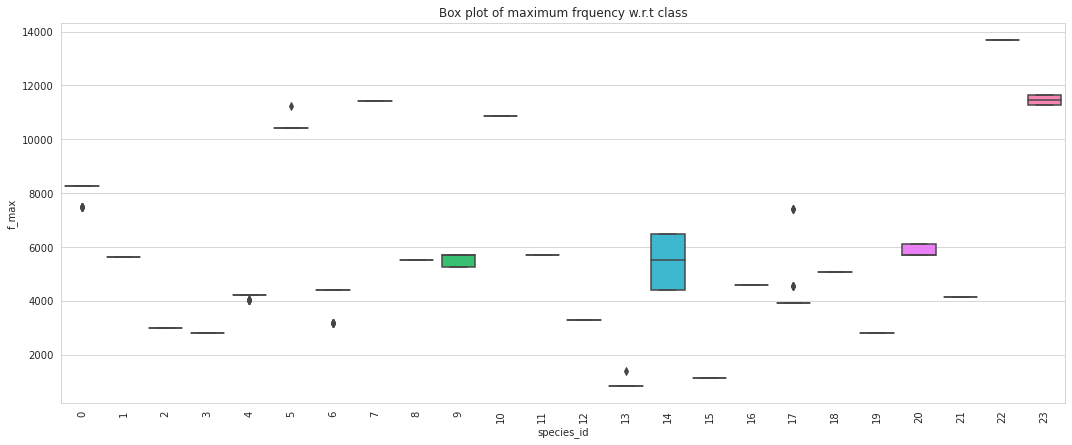

In [6]:
# Visualising box plot of maximum frequency w.r.t each class
plt.figure(figsize=(18,7))
sns.boxplot(x='species_id', y='f_max',data=data,saturation=1)
plt.title('Box plot of maximum frquency w.r.t class')
plt.ylabel('f_max')
plt.xticks(rotation=90)
plt.show()

In previous plot, we couldn't distinguish between class 5 and 7 but here these are easily separable.   
Class 19 can be easily separated from class 13,15 which wasn't clear in previous plot.
But there are still some classes which are not separable, for e.g class 8 and 9 are almost similar.     
Only class 17 has a outlier that is very far from other data point, all other classes outliers are not very big.

Now, we will load all the audio files using librosa library

In [7]:
Signals=[] # This will contain the signals generated from audio files
Durations=[] # This will contain duration of every recording after being sliced
for i in tnrange(data.shape[0]):
    path = '/kaggle/input/rfcx-species-audio-detection/train/{}.flac'.format(data['recording_id'][i])
    signal,sample_rate=librosa.load(path,sr=None) #Audio files are already encoded with sample rate of 
                                                   #  48000, so we don't need to resample them.
    signal=signal[int(data['t_min'][i]*48000):int(data['t_max'][i]*48000)+1]
    # Here we are slicing the sudio files according to the time at which that species was heard.
    duration = librosa.get_duration(signal,48000) # This will compute duration of audio in seconds
    Signals.append(signal)
    Durations.append(duration)

#### Now, we will analyse length of our audio sequences

In [26]:
len_seq=[ len(k) for k in Signals] # This will create an array for length of audio sequence

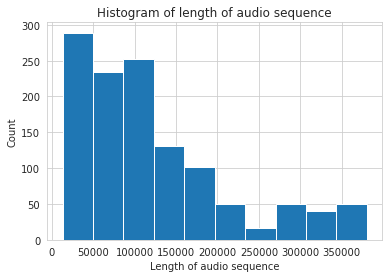

In [28]:
# Histogram plot for length of audio sequence
plt.hist(len_seq)
plt.xlabel('Length of audio sequence')
plt.ylabel('Count')
plt.title('Histogram of length of audio sequence')
plt.show()

### 1.6 Are audio files are of same duration ?

Next, we will plot histogram of the duration

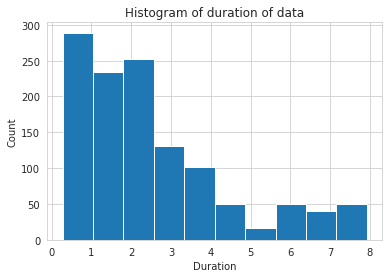

In [8]:
# Histogram plot for duration
plt.hist(Durations)
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Histogram of duration of data')
plt.show()

We can see that majority of the data points have duration less than 4 second but still there are considerable amount of data points which have duration between 4 and 8 second. Due to this, we will pad all the signal to make their length equal to the signal with maximum duration.

In [9]:
#print 0 to 100 percentile values with step size of 10 for data duration. 
per=[0,10,20,30,40,50,60,70,80,90,100]
for i in per:
    print('{}th percentile is '.format(i),np.percentile(Durations,i))

0th percentile is  0.2720208333333333
10th percentile is  0.6934166666666667
20th percentile is  0.8960208333333334
30th percentile is  1.1378125
40th percentile is  1.776
50th percentile is  1.8560208333333332
60th percentile is  2.4439166666666665
70th percentile is  3.1360208333333333
80th percentile is  3.4400208333333335
90th percentile is  6.083625
100th percentile is  7.9239375


This make things more clear, we can see 80% of the points have duration < 3.44 seconds but there are still 20% points which have duration >3.44 seconds. So, we will consider the point with the maximum duration.

### 1.7 Does songtype has anything to do with species ?

In [10]:
data.groupby('species_id').songtype_id.value_counts() # This will show us the count of each 
                                                      # songtype w.r.t each class

species_id  songtype_id
0           1              50
1           1              50
2           1              37
3           1              50
4           1              50
5           1              50
6           1              50
7           1              50
8           1              50
9           1              34
10          1              50
11          1              50
12          1              50
13          1              50
14          1              50
15          1              50
16          4              50
17          1              40
            4              28
18          1              50
19          1              43
20          1              40
21          1              50
22          1              44
23          1              50
            4              50
Name: songtype_id, dtype: int64

Here, we can see that only class 23 and 17 have data points from both songtypes amd all other classes only consist of songtype_id 1, we can also use this to separate other classes from 23 and 17. For e.g. we can also make prediction for songtype_id and if it is predicted as 4 with very high probability then we can be sure that datapoint must belong to class 17 or 23.

### 1.8 Does duration of audio has anything to do with species ?

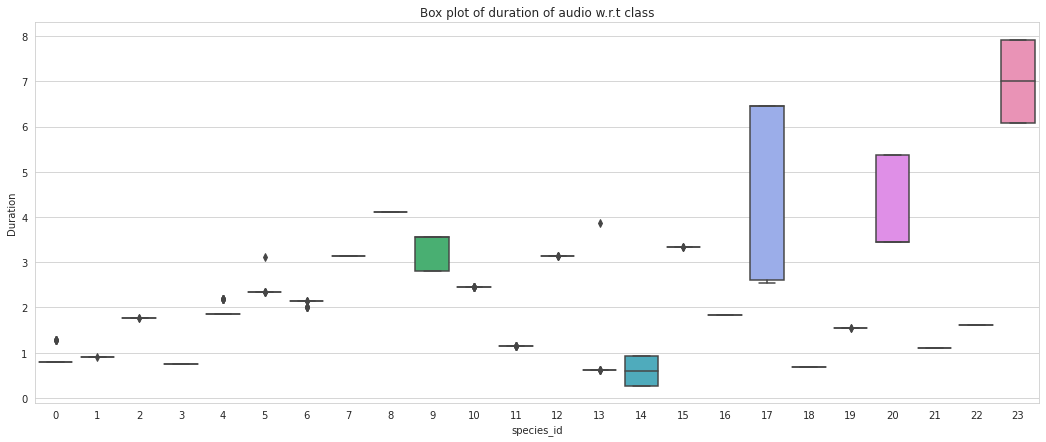

In [11]:
# Visualising box plot of duration of each class
plt.figure(figsize=(18,7))
sns.boxplot(x='species_id', y=Durations,data=data)
plt.title('Box plot of duration of audio w.r.t class')
plt.ylabel('Duration')
plt.show()

We can see that duration of audio can be helpful.      
Class 20 and 23 are easily separable. Similarly, class 0/1/3 can be separated from 2/3/4/5/6 and there also some other groups of classes which are separable.                           
Only class 13 has a big outlier, other the that outliers doesn't seem to be a big problem.      
There is a problem here, we can't actually use duration of audio to predict classes. This may work here but in real world audio will be fed continuously to the model and duration of audio will always be same so that will not help us in real world.

### 1.9 Is raw data any useful ?

In [12]:
raw_median=[np.median(i) for i in Signals]
data['raw_median']=raw_median    

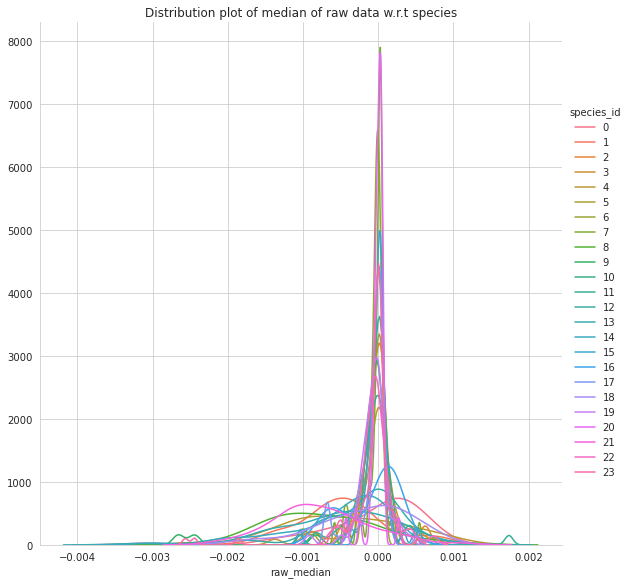

In [13]:
k=sns.FacetGrid(data,hue='species_id',height=8)
k.map(sns.distplot,'raw_median',hist=False).add_legend()
plt.title('Distribution plot of median of raw data w.r.t species')
plt.show()

We can hardly distinguish between classes from this plot. So, we can conclude that median of raw data doesn't seem to much useful for our classification problem.